# DSHARP Absorption
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/05/2024          |
| Updated |  09/01/2024          |

## Theoretical Model

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

Let $u_\mathrm{init}$ be the initial specific internal energy of the gas.
From the [classical ideal gas law](https://en.wikipedia.org/wiki/Equation_of_state#Classical_ideal_gas_law), in code units,

\begin{align*}
  T_\mathrm{init} &=  (\gamma - 1)u_\mathrm{init} \\
  u_\mathrm{init} &= \frac{P}{\rho(\gamma - 1)}
\end{align*}

h/r (r = L_0) = 0.06 (cf. original h/r_0 = 0.07)

/athinput.[pgen]
<problem>
...
kappa_a = 558.98169599999994  # absorption opacity [\rho_0*L_0]
kappa_a = 21.84 cm^2/g


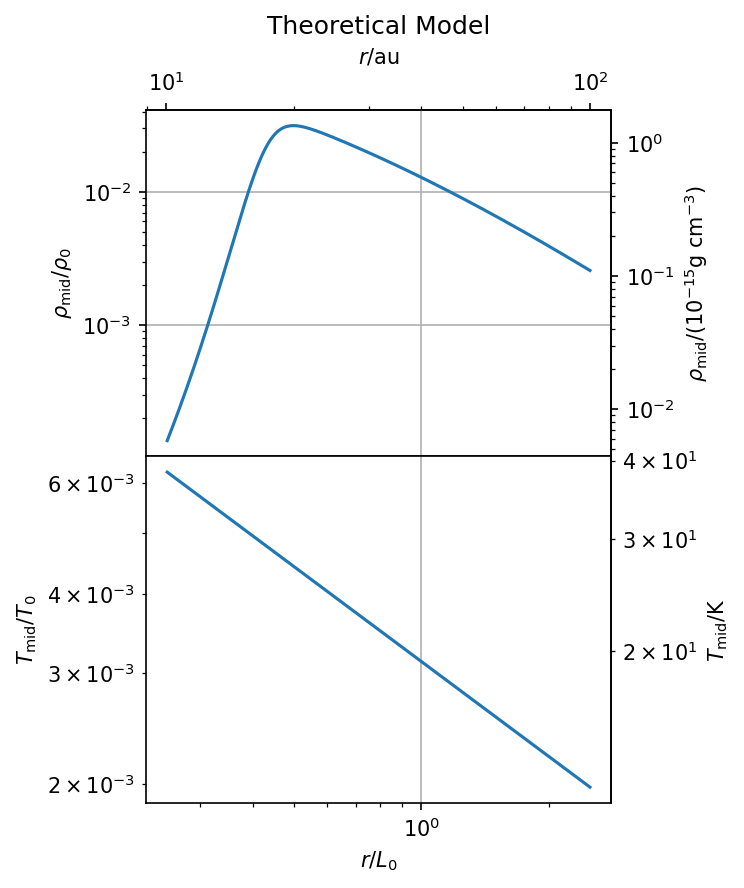

In [1]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# BEGIN /athinput.[pgen]
# <radiation>
T_unit           = 6.14e3              # T_0 [K]
length_unit      = 5.98e14             # L_0 [cm]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
molecular_weight = 0.6                 # \mu
# END /athinput.[pgen]

# Solar constants, astrophysical units and conversions
Lsun             = 3.83e33             # solar luminosity [erg/s]
Rsun             = 6.95700e10          # solar radius [cm]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]

# BEGIN [pgen].cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = np.abs(x1*np.sin(x2))
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# END [pgen].cpp

# extra quantities
kappa_star_cgs    = 10                 # [cm^2/g]
dgratio           = 100                # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.[pgen]
# <mesh>
nx1              = 1024                # Number of zones in X1-direction
x1min            = 0.250163663377926   # minimum value of X1
x1max            = 2.501636633779264   # maximum value of X1

nx2              = 128                 # Number of zones in X2-direction
x2min            = 0                   # minimum value of X2
x2max            = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor           = 1e-12               # minimum density

# <problem>
r0               = 0.425278227742474   # disk radial normalization [L_0]
rho0             = 0.2                 # disk density normalization [\rho_0]
p0_over_r0       = 4.80e-03            # (H/r0)^2
pslope           = -0.5                # pressure power-law index
dslope           = -2.25               # density power-law index
kappa_a          = 558.98169599999994  # absorption opacity [\rho_0*L_0]
# end athinput.[pgen]

# Compute dust opacity in code units
kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'h/r (r = L_0) = {(PoverR(1, np.pi/2, 0))**0.5:.2f}'\
      + f' (cf. original h/r_0 = {p0_over_r0**0.5:.2f})\n')
print('/athinput.[pgen]\n<problem>\n...')
print(rf'kappa_a = {kappa_a:.14f}  # absorption opacity [\rho_0*L_0]')
print(rf'kappa_a = {kappa_a/density_unit/length_unit:.2f} cm^2/g')

# Conversions
rad2deg          = 180/np.pi           # [deg]

# Generate fields
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rads, phis, zs = GetCylCoord(x1mesh, x2mesh, 0)
rho_field_theo = DenProfileCyl(rads, phis, zs)
rho_field_theo[rho_field_theo < dfloor] = dfloor
T_field_theo = PoverR(rads, phis, zs)
dtheta_theo = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta_theo)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=150)
axs[0].plot(x1v, rho_field_theo[j_mid, :])
axs[1].plot(x1v, T_field_theo[j_mid, :])

# Format secondary axes in cgs
def r2au(r):
  return r*L_au

def rho2cgs(rho):
  return rho*density_unit/1e-15

def T2cgs(T):
  return T*T_unit

ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
ax_rho = axs[0].secondary_yaxis('right', functions=(rho2cgs, rho2cgs))
ax_T = axs[1].secondary_yaxis('right', functions=(T2cgs, T2cgs))

ax_r.set(xlabel=r'$r$/au')
ax_r.minorticks_on()
ax_rho.set(ylabel=r'$\rho_\mathrm{mid}$/($10^{-15}$g cm$^{-3}$)')
ax_rho.minorticks_on()
ax_T.set(ylabel=r'$T_\mathrm{mid}$/K')
ax_T.minorticks_on()

# Format subplots
for ax in axs:
  ax.set(xscale='log', yscale='log')
  ax.grid()
  ax.minorticks_on()

axs[0].set(title='Theoretical Model', ylabel=r'$\rho_\mathrm{mid}/\rho_0$')
axs[1].set(xlabel=r'$r/L_0$',
           ylabel=r'$T_\mathrm{mid}/T_0$')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

## Code comparison

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

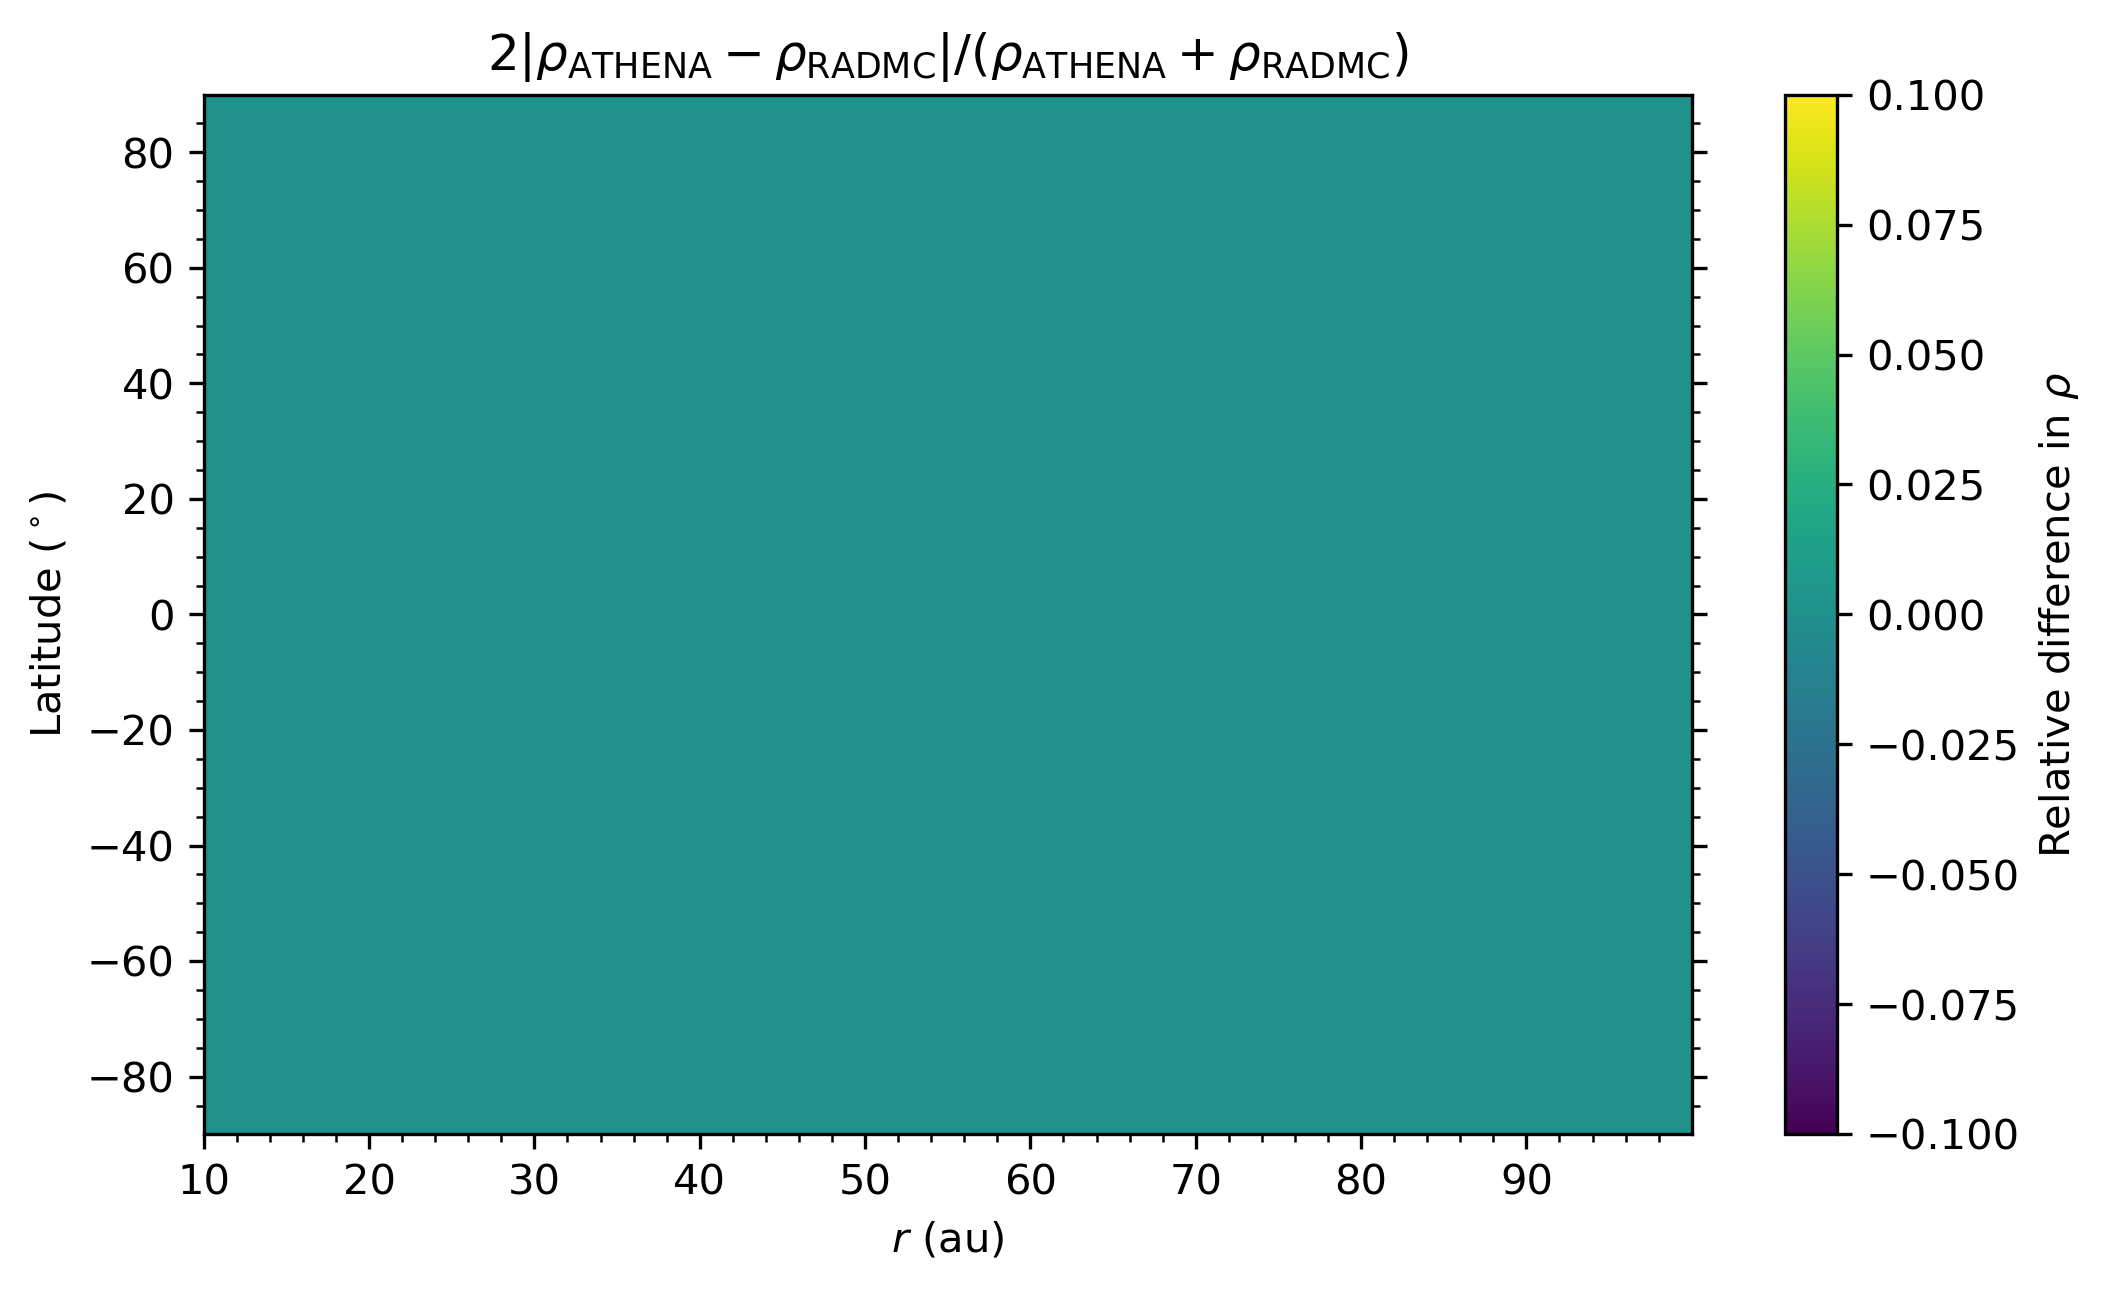

In [2]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# RADMC-3D
run = 'dsharp_abs'
path = f'/home/stanley/github/sabaronett/rad-hydro/radmc3d/{run}'
rhodust = np.load(f'{path}/dust_density.npz')['rhodust']

# Athena++
run = 'nfreq/4'
problem_id = 'dsharp'
path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-v3/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00000.athdf')
length_unit = athinput['radiation']['length_unit']
L_au = length_unit/au
density_unit = athinput['radiation']['density_unit']

# Plot
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
drho = athdf['rho'][0]*density_unit - rhodust[:,:,0,0].T
srho = athdf['rho'][0]*density_unit + rhodust[:,:,0,0].T
rel_diff = 2*np.abs(drho)/srho
im = ax.pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg, rel_diff)

# Format (sub)plots
plt.colorbar(im, label=r'Relative difference in $\rho$')
ax.minorticks_on()
ax.set(xlabel='$r$ (au)', ylabel=r'Latitude ($^\circ$)',
       title=r'$2|\rho_\mathrm{ATHENA} - \rho_\mathrm{RADMC}|$'\
                       +r'$/(\rho_\mathrm{ATHENA} + \rho_\mathrm{RADMC})$')
ax.tick_params(axis='both', which='both', right=True)

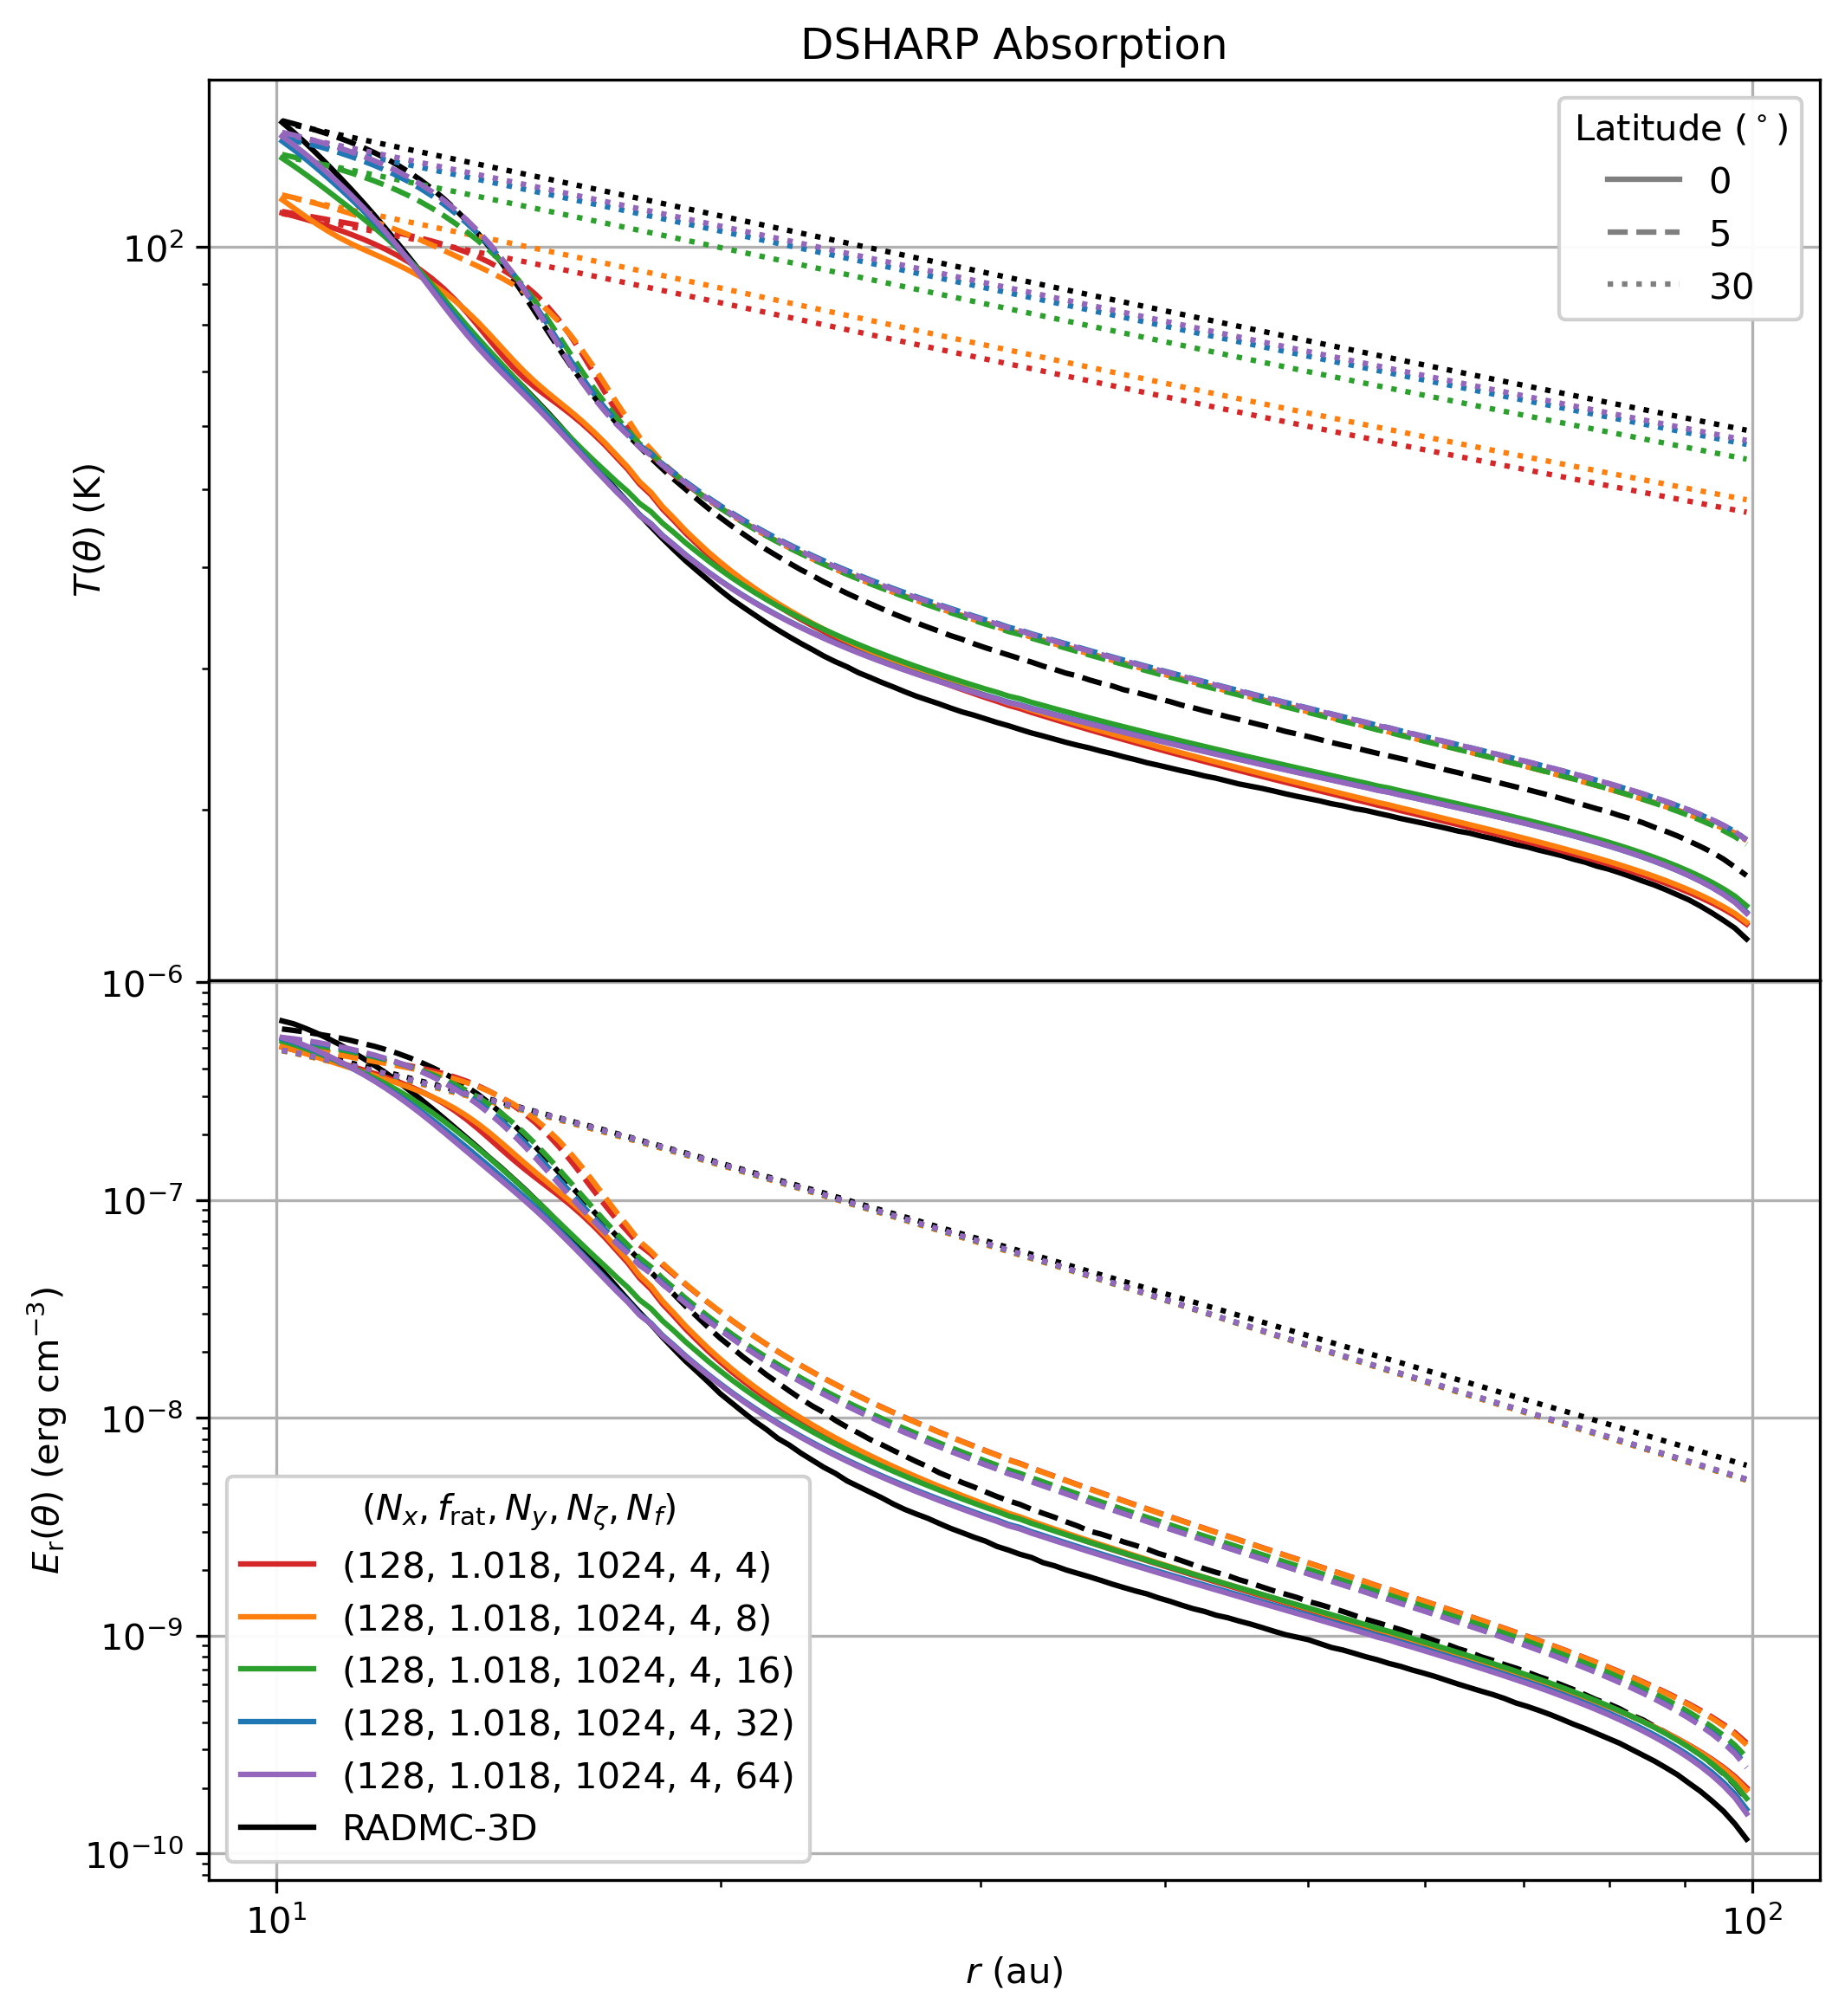

In [3]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green',  'tab:blue', 'tab:purple',
              'tab:olive', 'tab:cyan', 'tab:pink', 'tab:brown', 'tab:gray']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
totmeanint = np.load(f'{path}/total_mean_intensity.npz')['totmeanint']
Er = 4*np.pi*totmeanint[:,:,0]/c_speed
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    axs[0].plot(grid.x/au, dusttemp[:,j,0,0], color='k', ls=lss[th])
    axs[1].plot(grid.x/au, Er[:,j], color='k', ls=lss[th])

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-v3/nfreq'
runs = ['4', '8', '16', '32', '64']
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  nx1 = athinput['mesh']['nx1']
  try:
    x1rat = athinput['mesh']['x1rat']
  except KeyError:
    x1rat = 1.0
  nx2 = athinput['mesh']['nx2']
  nzeta = athinput['radiation']['nzeta']
  length_unit = athinput['radiation']['length_unit']
  T_unit = athinput['radiation']['T_unit']
  L_au = length_unit/au
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /nx2
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
  T_field = athdf['press'][0]/athdf['rho'][0]
  Er_field = np.zeros_like(T_field)
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Er_field += athdf[f'Er_{f}'][0]
  except KeyError:
    Er_field = athdf['Er'][0]
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    axs[0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color=tab_colors[i],
                ls=lss[th])
    axs[1].plot(athdf['x1v']*L_au, Er_field[j, :]*arad*T_unit**4,
                color=tab_colors[i], ls=lss[th])
    if i == 0:
      ls_thetas.append(axs[0].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
  c_solns.append(axs[1].plot([], [], color=tab_colors[i],
                 label=f'({nx1}, {x1rat:.3f}, {nx2}, {nzeta}, {N_f})')[0])
c_solns.append(axs[1].plot([], [], color='k', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
ls_legend = axs[0].legend(title=r'Latitude ($^\circ)$', handles=ls_thetas)
color_legend = axs[1].legend(title=r'$(N_x, f_\mathrm{rat}, N_y, N_\zeta, N_f)$',
                             handles=c_solns)
# soln_legend = axs[1].legend(handles=ref_soln)
axs[0].add_artist(ls_legend)
axs[1].add_artist(color_legend)
# axs[1].add_artist(soln_legend)

# Format (sub)plots
for ax in axs:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both')

axs[0].set(ylabel=r'$T(\theta)$ (K)',
           title='DSHARP Absorption')
axs[1].set(xlabel=r'$r$ (au)', ylabel=r'$E_\mathrm{r}(\theta)$ (erg cm$^{-3}$)')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

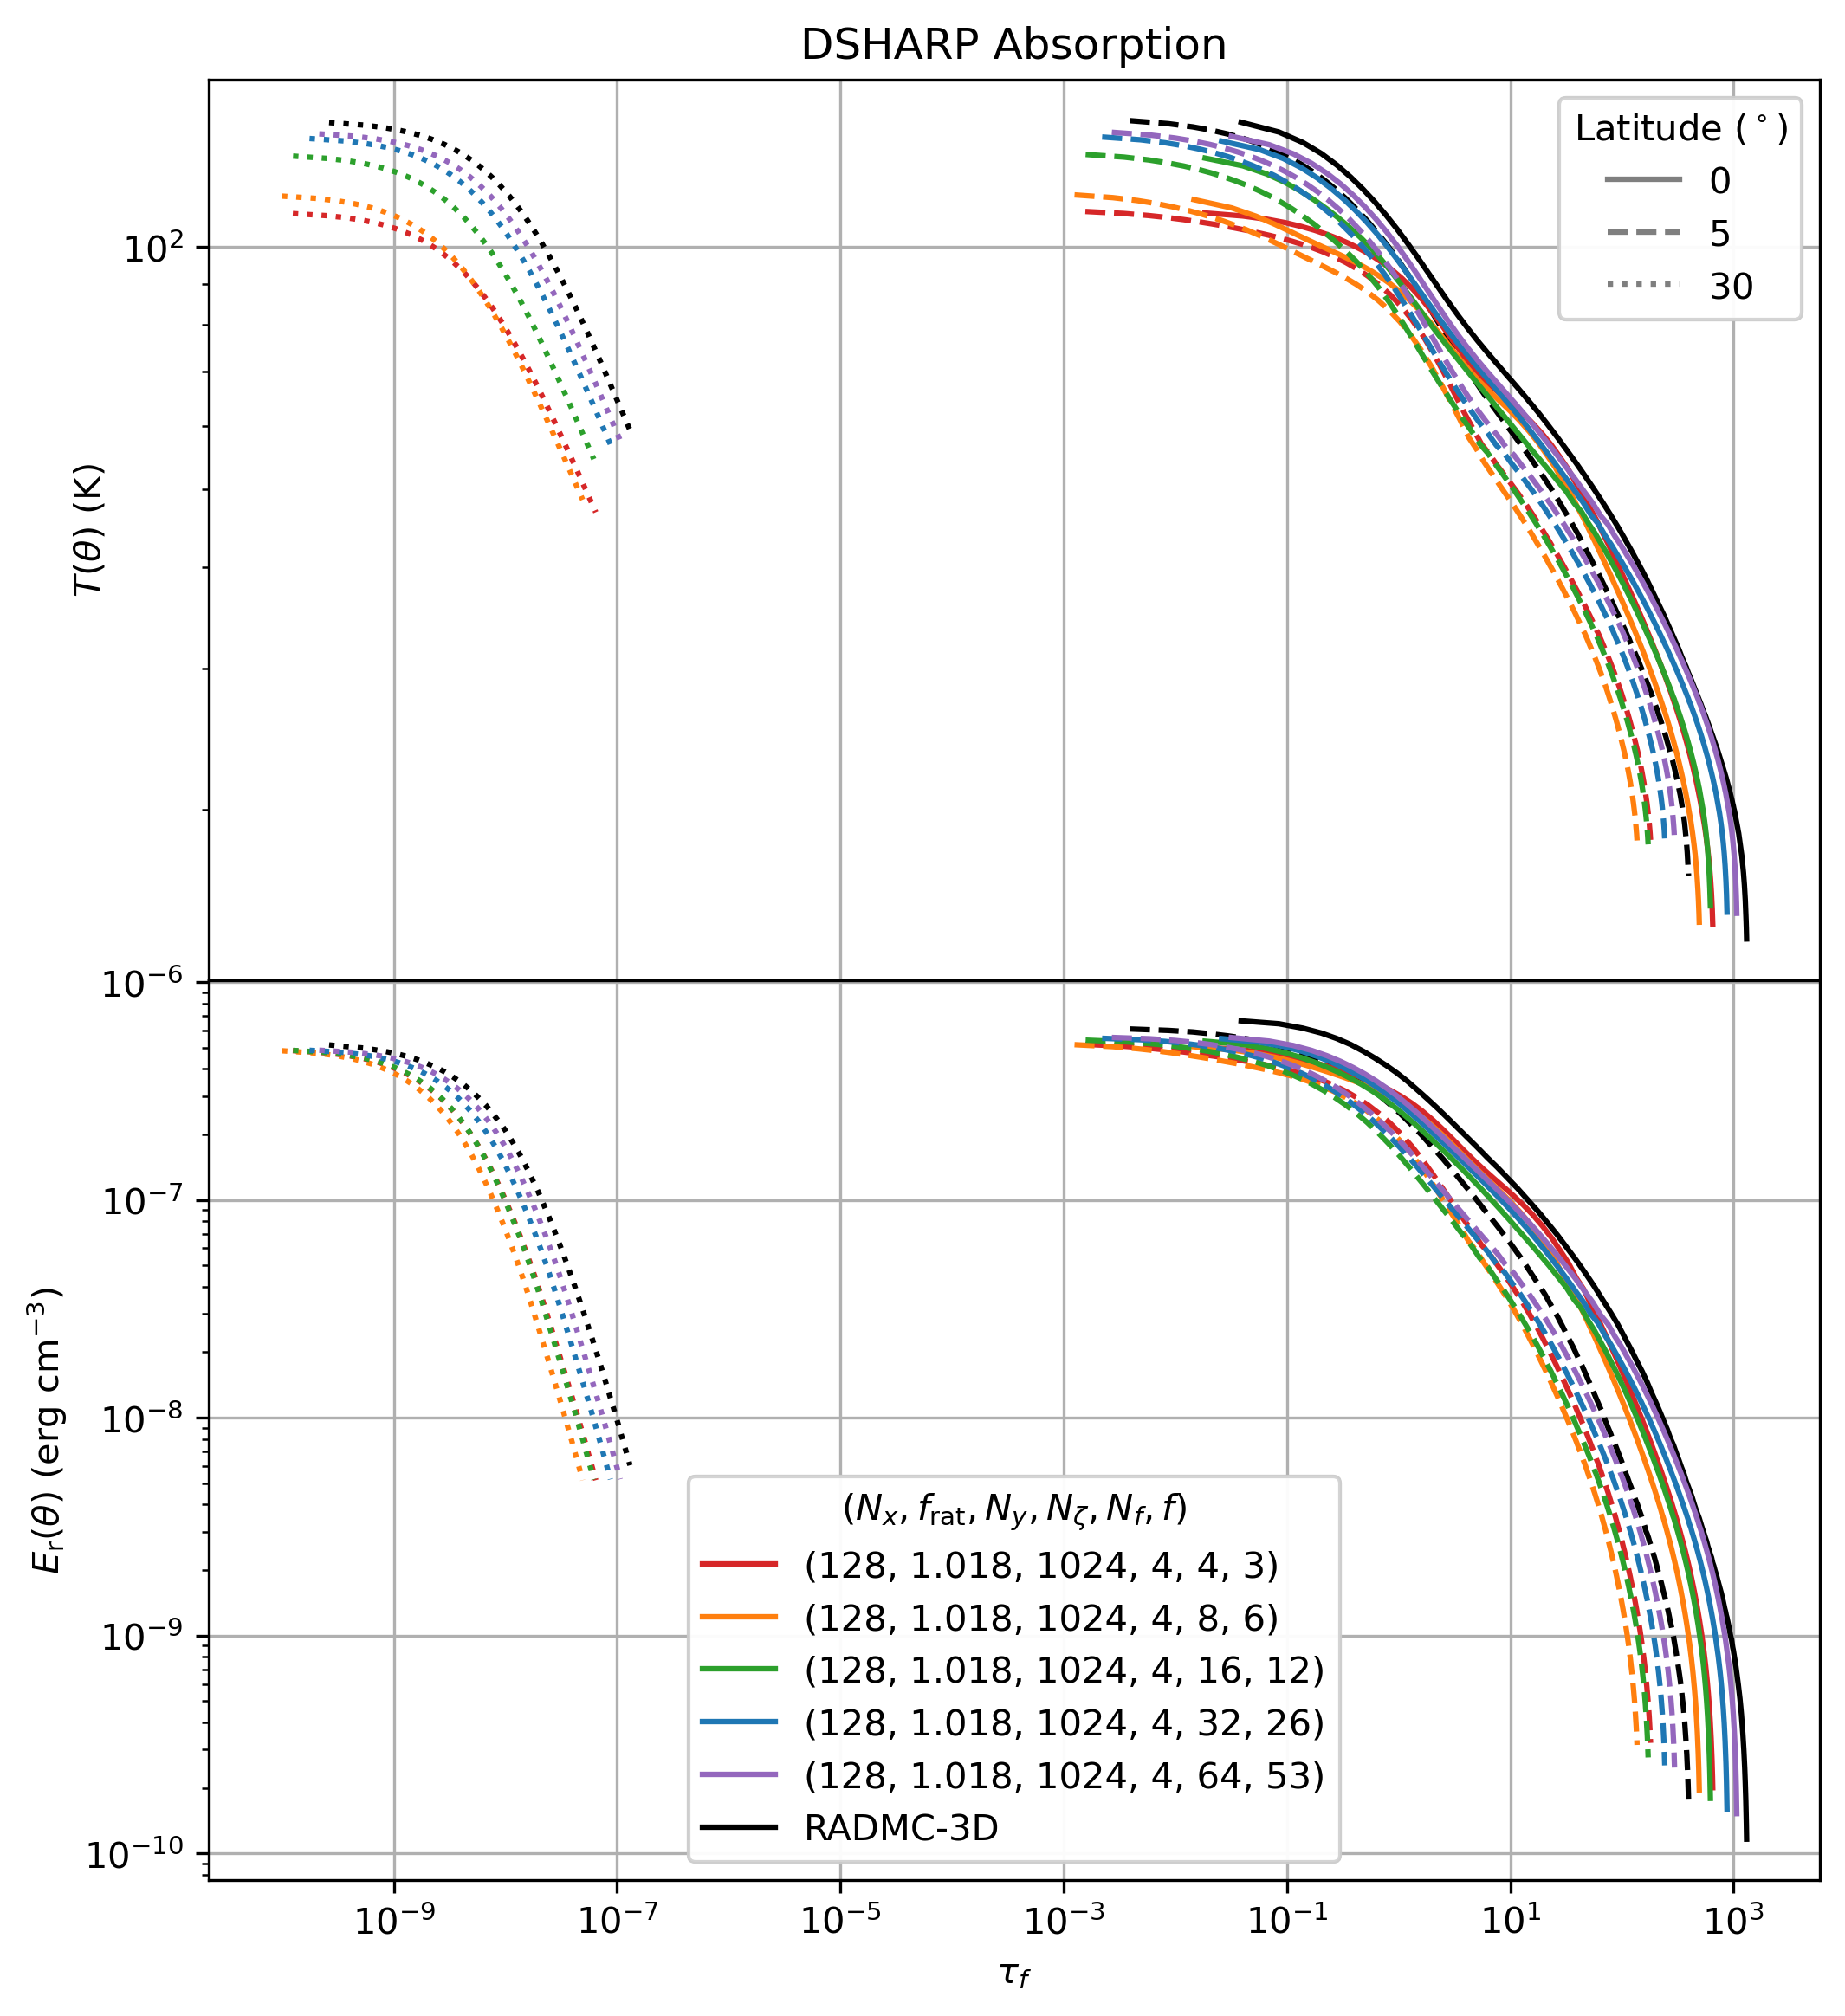

In [4]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green',  'tab:blue', 'tab:purple',
              'tab:olive', 'tab:cyan', 'tab:pink', 'tab:brown', 'tab:gray']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
totmeanint = np.load(f'{path}/total_mean_intensity.npz')['totmeanint']
Er = 4*np.pi*totmeanint[:,:,0]/c_speed
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    axs[0].plot(taux[:,j,0], dusttemp[:,j,0,0], color='k', ls=lss[th])
    axs[1].plot(taux[:,j,0], Er[:,j], color='k',ls=lss[th])

# Athena++
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-v3/nfreq'
runs = ['4', '8', '16', '32', '64']
bands = [3, 6, 12, 26, 53]
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  nx1 = athinput['mesh']['nx1']
  try:
    x1rat = athinput['mesh']['x1rat']
  except KeyError:
    x1rat = 1.0
  nx2 = athinput['mesh']['nx2']
  nzeta = athinput['radiation']['nzeta']
  nfreq = athinput['radiation']['n_frequency']
  length_unit = athinput['radiation']['length_unit']
  T_unit = athinput['radiation']['T_unit']
  L_au = length_unit/au
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
  dtau = athdf[f'Sigma_a_{bands[i]}'][0]*np.diff(athdf['x1f'])
  tau = np.cumsum(dtau, axis=1)
  T_field = athdf['press'][0]/athdf['rho'][0]
  Er_field = np.zeros_like(T_field)
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Er_field += athdf[f'Er_{f}'][0]
  except KeyError:
    Er_field = athdf['Er'][0]
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    # if i == 3 and theta_deg == 85:
    #   j += 1
    axs[0].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i], ls=lss[th])
    axs[1].plot(tau[j, :], Er_field[j, :]*arad*T_unit**4, color=tab_colors[i],
                ls=lss[th])
    if i == 0:
      ls_thetas.append(axs[0].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
  c_solns.append(axs[1].plot([], [], color=tab_colors[i],
                 label=f'({nx1}, {x1rat:.3f}, {nx2}, {nzeta}, {nfreq}, {bands[i]})')[0])
c_solns.append(axs[1].plot([], [], color='k', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
ls_legend = axs[0].legend(title=r'Latitude ($^\circ)$', handles=ls_thetas)
color_legend = axs[1].legend(title=r'$(N_x, f_\mathrm{rat}, N_y, N_\zeta, N_f, f)$',
                             handles=c_solns)
# soln_legend = axs[1].legend(handles=ref_soln)
axs[0].add_artist(ls_legend)
axs[1].add_artist(color_legend)
# axs[1].add_artist(soln_legend)

# Format (sub)plots
for ax in axs:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both')

axs[0].set(ylabel=r'$T(\theta)$ (K)',
           title='DSHARP Absorption')
axs[1].set(xlabel=r'$\tau_f$', ylabel=r'$E_\mathrm{r}(\theta)$ (erg cm$^{-3}$)')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

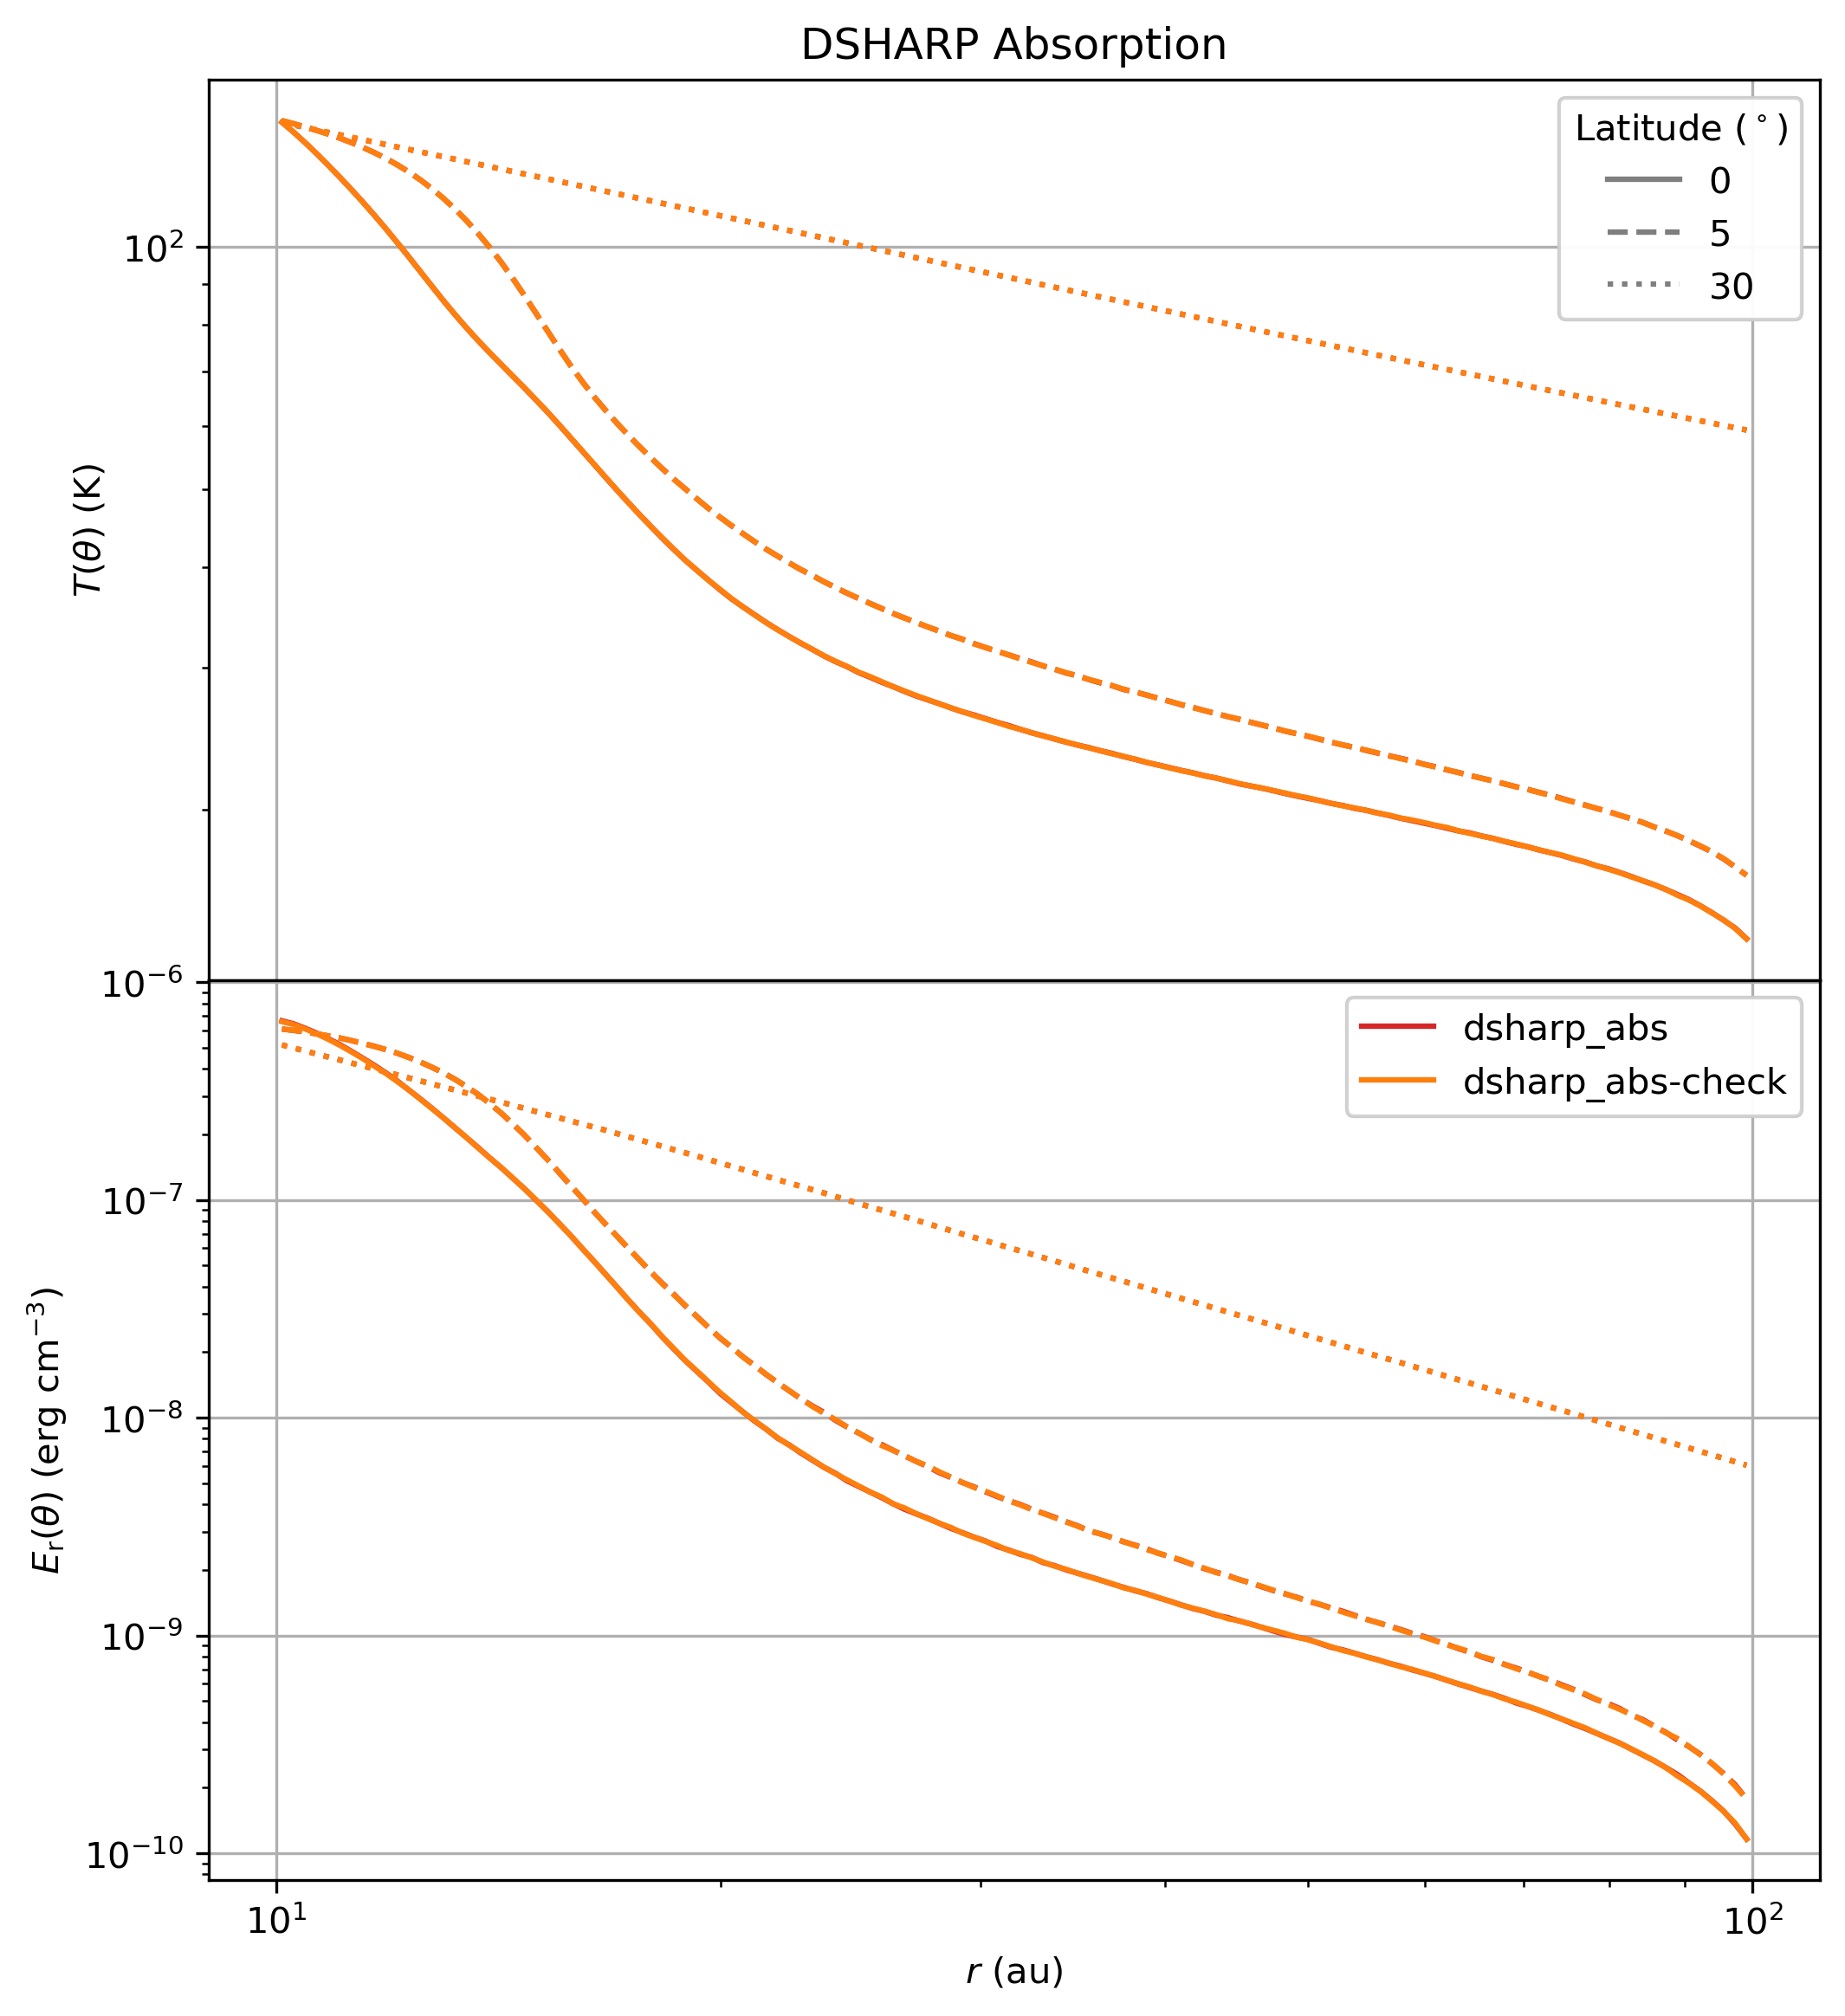

In [5]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green',  'tab:blue', 'tab:purple',
              'tab:olive', 'tab:cyan', 'tab:pink', 'tab:brown', 'tab:gray']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
runs = ['dsharp_abs', 'dsharp_abs-check']
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
  dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
  totmeanint = np.load(f'{path}/total_mean_intensity.npz')['totmeanint']
  Er = 4*np.pi*totmeanint[:,:,0]/c_speed
  dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)
  for th, theta_deg in enumerate(theta_degs):
      j = int(theta_deg/rad2deg/dtheta)
      axs[0].plot(grid.x/au, dusttemp[:,j,0,0], color=tab_colors[i],
                  ls=lss[th])
      axs[1].plot(grid.x/au, Er[:,j], color=tab_colors[i], ls=lss[th])
      if i == 0:
        ls_thetas.append(axs[0].plot([], [], color='tab:gray', ls=lss[th],
                         label=rf'${90-theta_deg}$')[0])
  c_solns.append(axs[1].plot([], [], color=tab_colors[i],
                 label=f'{run}')[0])

# Plot ghost points for colorless line style and add legends
ls_legend = axs[0].legend(title=r'Latitude ($^\circ)$', handles=ls_thetas)
color_legend = axs[1].legend(handles=c_solns)
# soln_legend = axs[1].legend(handles=ref_soln)
axs[0].add_artist(ls_legend)
axs[1].add_artist(color_legend)
# axs[1].add_artist(soln_legend)

# Format (sub)plots
for ax in axs:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both')

axs[0].set(ylabel=r'$T(\theta)$ (K)',
           title='DSHARP Absorption')
axs[1].set(xlabel=r'$r$ (au)', ylabel=r'$E_\mathrm{r}(\theta)$ (erg cm$^{-3}$)')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

In [6]:
np.min(dusttemp)

13.825786330043865

In [7]:
np.max(dusttemp)

143.5416399708775

In [8]:
# ~300 (272) CPUs for 2 levels of refinement
# 11 CPU hours for 128 CPUs to 0.1 tlim

Ncpu = 300
run_3707144 = 11 # [CPU hours] 128 CPUs to 7e7 s
time_base = run_3707144/128/7e7 # hours/CPU/s
T_orb = 928735200 # seconds
time_est = Ncpu*100*T_orb*time_base

print(f'time_base = {time_base:.2e}')
print(f'time_est = {time_est:.2e}')

time_base = 1.23e-09
time_est = 3.42e+04


## Poster

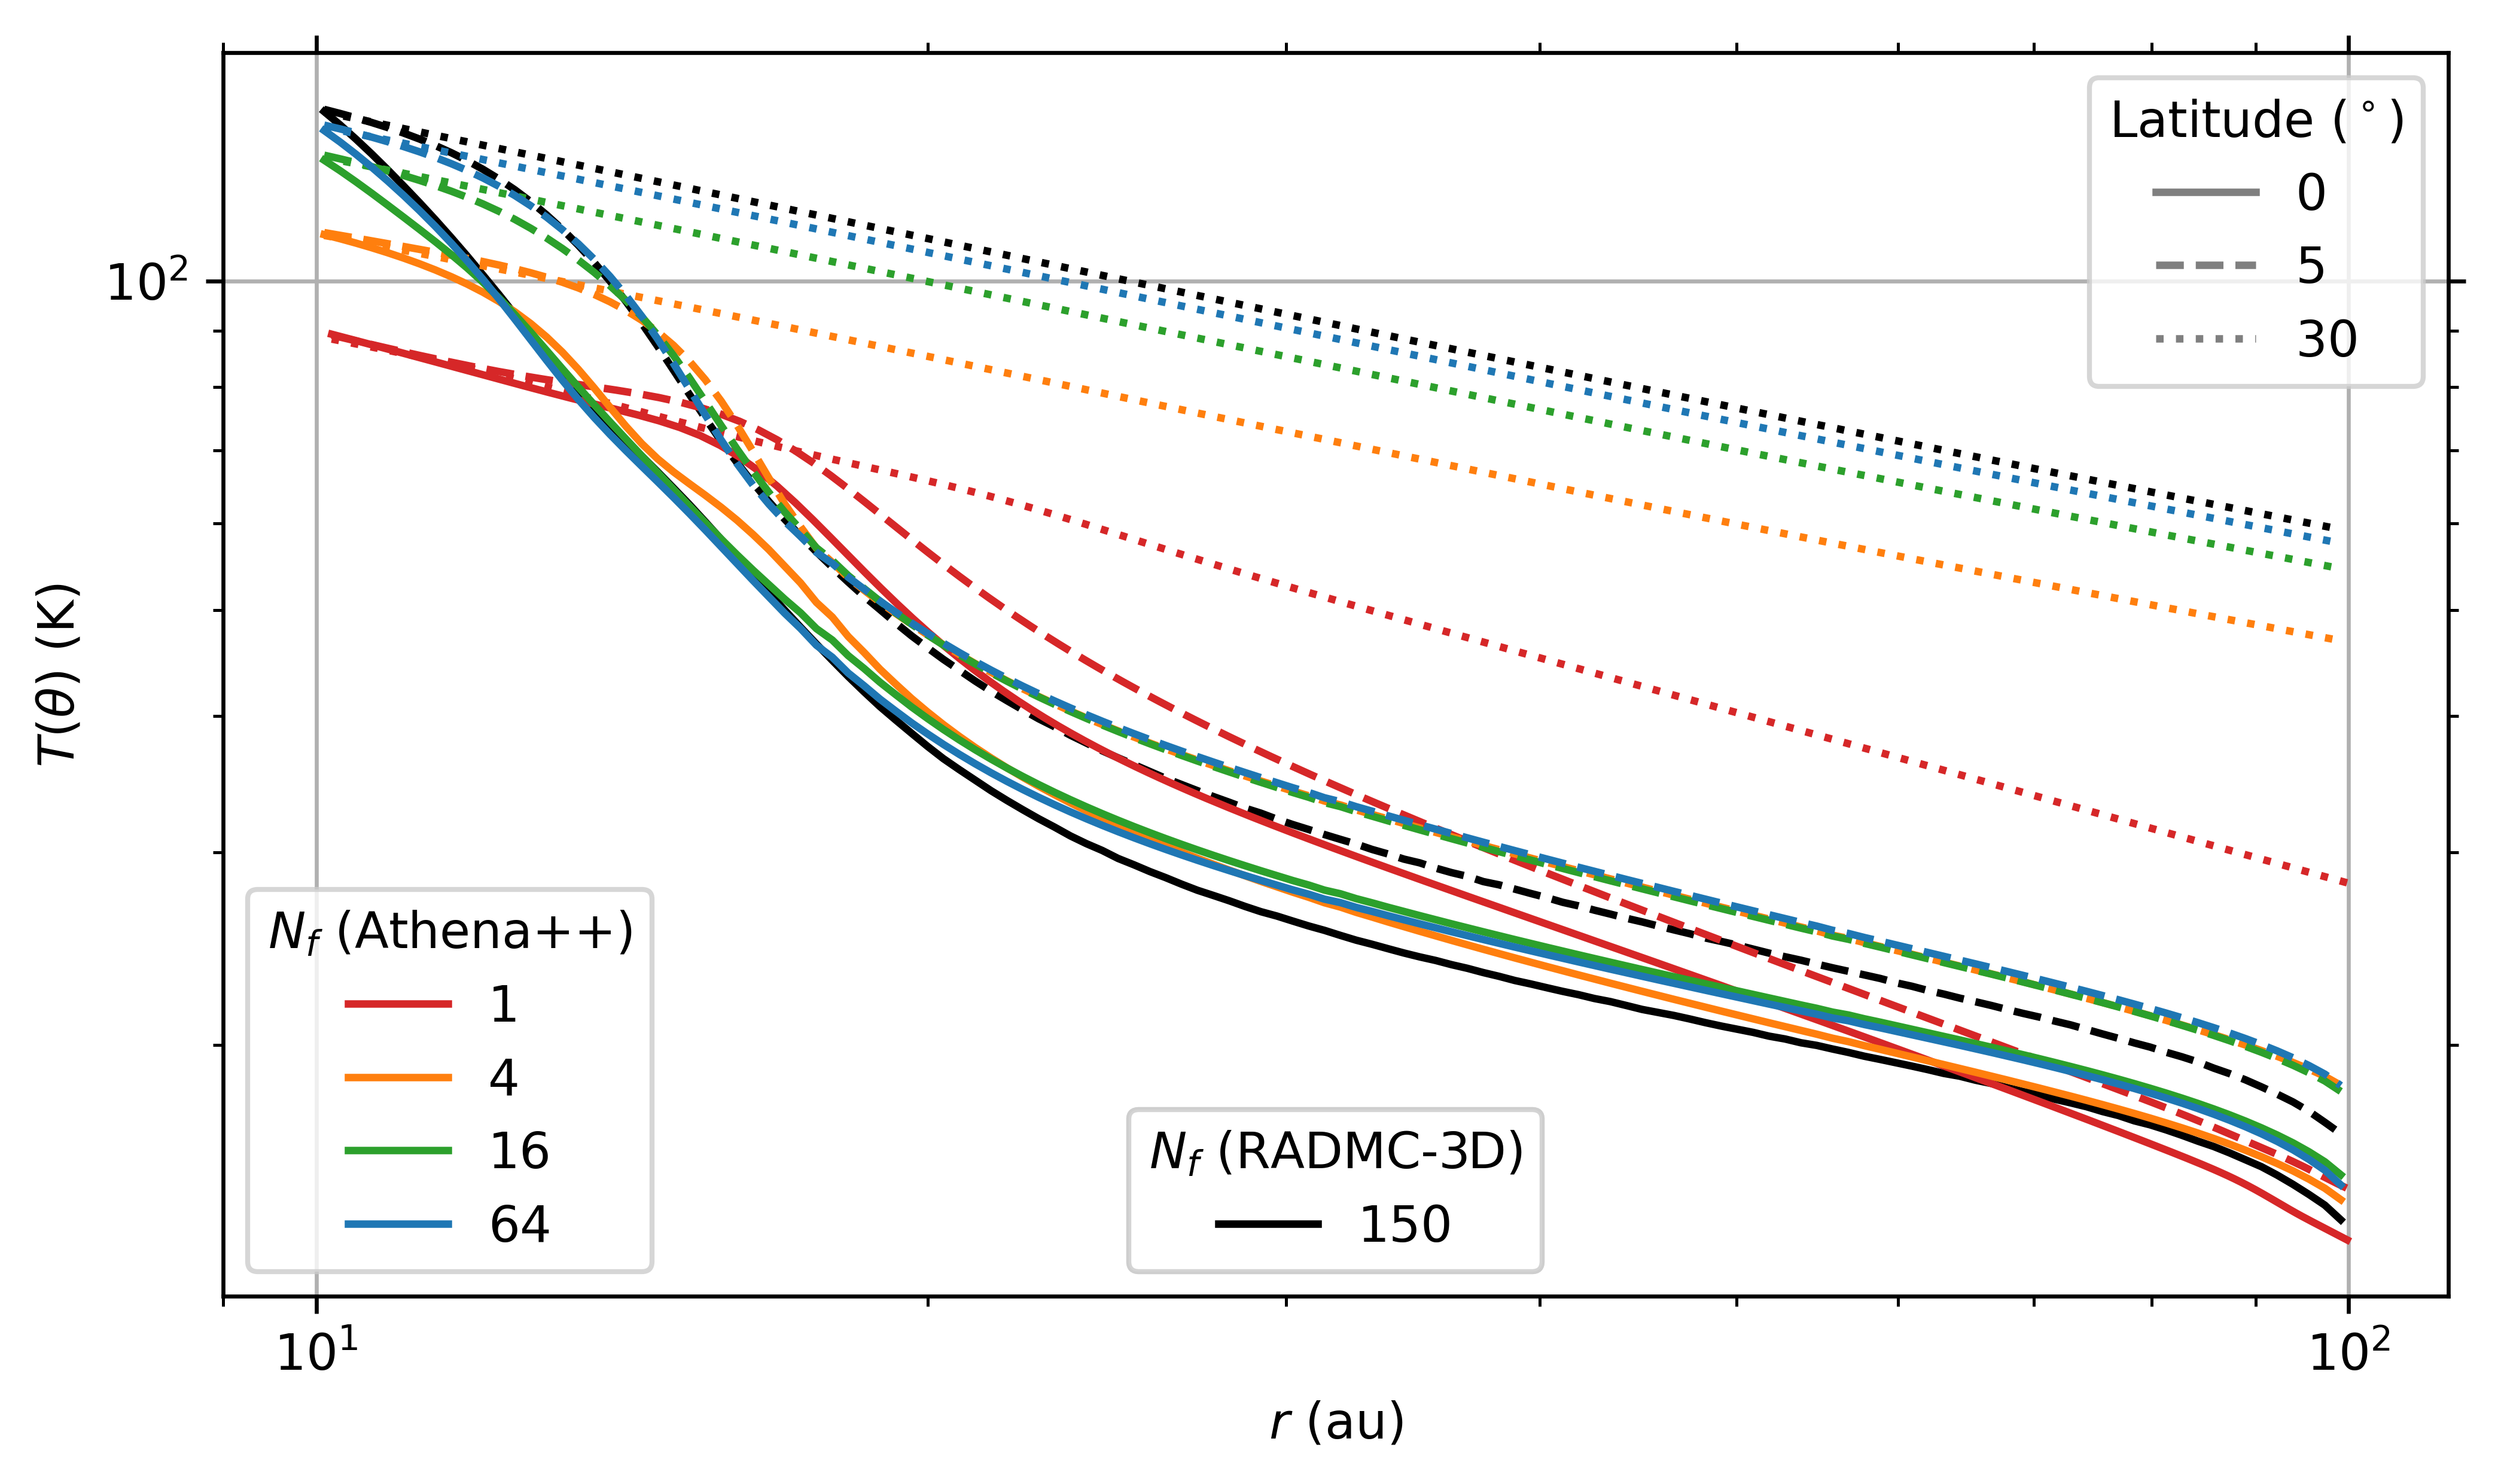

In [9]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=600)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
# lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'dsharp_abs'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)
ref_soln.append(ax.plot([], [], color='black', label='150')[0])
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(grid.x/au, dusttemp[:,j,0,0], color='k', ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Read and plot Athena++ solutions
problem_id = 'dsharp'
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-v3/nfreq'
runs = ['1', '4', '16', '64']

for i, run in enumerate(runs):
    path = f'{base}/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
             /athinput['mesh']['nx2']
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    T_field = athdf['press'][0]/athdf['rho'][0]*T_0
    c_solns.append(ax.plot([], [], tab_colors[i], label=f'{run}')[0])

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_0/natconst.au, T_field[j, :], tab_colors[i],
                ls=lss[th])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'Latitude ($^\circ)$', handles=ls_thetas,
                       loc='upper right')
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
radmc_legend = plt.legend(title=r'$N_f$ (RADMC-3D)', handles=ref_soln,
                          loc='lower center')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)
ax.add_artist(radmc_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)', xscale='log',
       yscale='log')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig('temp_profiles.png', bbox_inches='tight', pad_inches=0.01)